In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import h5py
import json
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# Specify location of data
folder = 'LOSC_Event_tutorial/'
plt.style.use('seaborn-muted')

# READ IN DATA

In [2]:
def read_template(filename):
    dataFile = h5py.File(filename,'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    meta = dataFile['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0*duration)/len(strain)
    dataFile.close()
    return strain, dt, utc

In [3]:
file_names = os.listdir(folder)

# Save events from Hanford, Livingston and corresponding GW template
L_events = []
H_events = []
for file in file_names: 
    if file[0] == 'H':
        H_events.append(file)
        for j in file_names: 
            if j[:] == 'L-L1_LOSC_4' + file[11:]:
                L_events.append(j)

# Save GW templates manually, making sure it corresponds to correct event
GW = ['GW170104_4_template.hdf5','GW151226_4_template.hdf5','LVT151012_4_template.hdf5','GW150914_4_template.hdf5']

In [4]:
print('''
Handford Events:
-----------------
{0}

Livinston Events:
-----------------
{1}

GW Templates:
-----------------
{2}
'''.format(H_events, L_events, GW))


Handford Events:
-----------------
['H-H1_LOSC_4_V1-1167559920-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'H-H1_LOSC_4_V2-1126259446-32.hdf5']

Livinston Events:
-----------------
['L-L1_LOSC_4_V1-1167559920-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'L-L1_LOSC_4_V2-1126259446-32.hdf5']

GW Templates:
-----------------
['GW170104_4_template.hdf5', 'GW151226_4_template.hdf5', 'LVT151012_4_template.hdf5', 'GW150914_4_template.hdf5']



# PART A: ESTIMATING NOISE MODEL

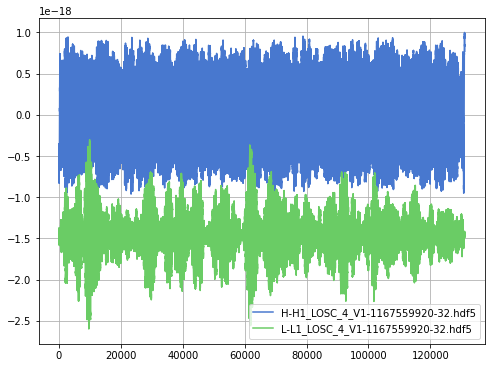

In [5]:
# Let's run through an example, choosing the last event. 
index = 0
strain_H, dt, utc_H = read_file(folder + H_events[index])
strain_L, dt, utc_L = read_file(folder + L_events[index])
th, tl = read_template(folder + GW[index])
Npts = len(strain_H)

# Plot strain
plt.figure(figsize=(8,6))
plt.plot(strain_H, label = H_events[index])
plt.plot(strain_L, label = L_events[index])
plt.legend()
plt.grid()
plt.show()


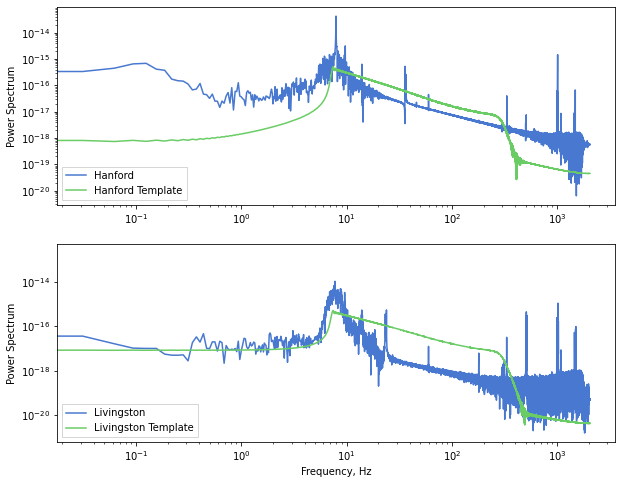

In [7]:
# Plot power spectrum of strain with template on top to get an idea of where to window our data. 
# Hanford
ps_H = np.fft.rfft(strain_H)
ps_th = np.fft.rfft(th)

# Livingston
ps_L = np.fft.rfft(strain_L)
ps_tl = np.fft.rfft(tl)

N_spec = len(ps_H)

# Get frequencies
freqs = np.linspace(0,2048,N_spec)

# Plot 
fig, axs = plt.subplots(2,figsize=(10,8))


axs[0].loglog(freqs, np.abs(ps_H), label = 'Hanford')
axs[0].loglog(freqs, np.abs(ps_th), label = 'Hanford Template')
leg0 = axs[0].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)
#axs[0].set_xlim(20,2000)

axs[1].loglog(freqs, np.abs(ps_L), label = 'Livingston')
axs[1].loglog(freqs, np.abs(ps_tl), label = 'Livingston Template')
leg1 = axs[1].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)
#axs[1].set_xlim(20,2000)


for ax in axs.flat:
    ax.set(ylabel='Power Spectrum')

plt.xlabel('Frequency, Hz')

plt.show()


##### Notice that in the above plots, the power spectrum of the templates are strongest from ~20 Hz to ~2000 Hz, so we will window the function around this section. 

### Windowing

All the data we care about lies in the frequency range of 20 Hz to 2000 Hz in the fourier domain. To window our function, we'll use trial and error with the template to find a reasonable window function. My friends and I looked at a few of the window functions on the wikipedia page and found the Planck Taper Window function which seems to do a similar job as the cosine that Jon wrote in class. However, I decided to go with the planck window since it has reduced the ringing in the windowed power spectrum. 

In [8]:
def make_window(n):
    x=np.linspace(-np.pi,np.pi,n)
    return 0.5+0.5*np.cos(x)

def make_flat_window(n,m):
    tmp=make_window(m)
    win=np.ones(n)
    mm=m//2
    win[:mm]=tmp[:mm]
    win[-mm:]=tmp[-mm:]
    return win

def planck_taper_window(N, eps = 0.1):
    # Wrote this manually. Taken from https://en.wikipedia.org/wiki/Window_function. 
    func = np.ones(N)
    n = np.arange(N)
    func[0] = 0
    func[-1] = 0
    func[1:int(eps*N)] = (1  + np.exp((eps*N/n[1:int(eps*N)]) - (eps*N/(eps*N - n[1:int(eps*N)]))))**(-1)
    func[-int(eps*N):-1] = ((1  + np.exp((eps*N/n[1:int(eps*N)]) - (eps*N/(eps*N - n[1:int(eps*N)]))))**(-1))[::-1]
    return func

/tmp/ipykernel_6639/1514463572.py:19: RuntimeWarning: overflow encountered in exp
  func[1:int(eps*N)] = (1  + np.exp((eps*N/n[1:int(eps*N)]) - (eps*N/(eps*N - n[1:int(eps*N)]))))**(-1)
/tmp/ipykernel_6639/1514463572.py:20: RuntimeWarning: overflow encountered in exp
  func[-int(eps*N):-1] = ((1  + np.exp((eps*N/n[1:int(eps*N)]) - (eps*N/(eps*N - n[1:int(eps*N)]))))**(-1))[::-1]


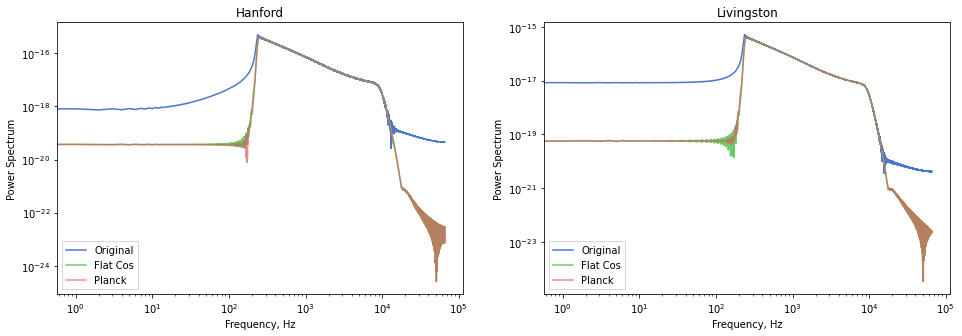

In [9]:
# Let's compare the flat cos window to the planck taper window and how they act on the templates
cos = make_flat_window(Npts, Npts//5)
planck = planck_taper_window(Npts, eps = 0.1)

# Plot
fig, axs = plt.subplots(1,2, figsize = (16,5))
axs[0].loglog(np.abs(np.fft.rfft(th)), label = 'Original')
axs[0].loglog(np.abs(np.fft.rfft(cos*th)),label = 'Flat Cos')
axs[0].loglog(np.abs(np.fft.rfft(planck*th)),alpha = 0.7, label = 'Planck')
axs[0].set_title('Hanford')
leg0 = axs[0].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)

axs[1].loglog(np.abs(np.fft.rfft(tl)), label = 'Original')
axs[1].loglog(np.abs(np.fft.rfft(cos*tl)),label = 'Flat Cos')
axs[1].loglog(np.abs(np.fft.rfft(planck*tl)),alpha = 0.7, label = 'Planck')
axs[1].set_title('Livingston')
leg0 = axs[1].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)


for ax in axs.flat:
    ax.set(xlabel = 'Frequency, Hz', ylabel='Power Spectrum')


##### In both cases, the flat cosine and planck taper window do roughly the same thing and both include roughly all the data we care about (i.e. where the power spectrum of the template is large). However, I chose to use the planck taper because it has less ringing near the low frequencies (around 100 Hz). 

### Smoothing Power Spectrum

The next step, now that we have a window function that we're happy with, is to smooth the resulting power spectrum of the strain * window. Since we want the power spectrum to be smoothed (which lives in the Fourier domain), we need to convolve a gaussian with the power spectrum in the Fourier domain. This requires doing the FFT(iFFT(PS) * iFFT(kernel)) 

In [10]:
def gauss_kernel(freqs, sigma):
    
    kernel = np.exp(-(freqs)**2 / (2*sigma **2))/(np.sqrt(2*np.pi*sigma**2))
    
    return kernel

/tmp/ipykernel_6639/1514463572.py:19: RuntimeWarning: overflow encountered in exp
  func[1:int(eps*N)] = (1  + np.exp((eps*N/n[1:int(eps*N)]) - (eps*N/(eps*N - n[1:int(eps*N)]))))**(-1)
/tmp/ipykernel_6639/1514463572.py:20: RuntimeWarning: overflow encountered in exp
  func[-int(eps*N):-1] = ((1  + np.exp((eps*N/n[1:int(eps*N)]) - (eps*N/(eps*N - n[1:int(eps*N)]))))**(-1))[::-1]
/home/mattias/anaconda3/envs/main_env/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


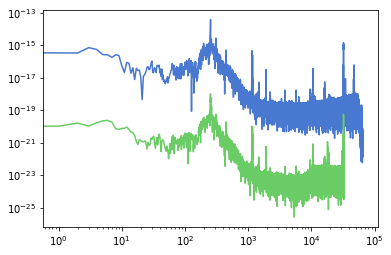

In [22]:
kernel_for_ps = gauss_kernel(freqs, 0.1)

window = planck_taper_window(Npts)

sft = np.fft.rfft(window*strain_H)

convolved_ps = np.fft.rfft(np.fft.ifft(sft)*np.fft.ifft(kernel_for_ps))

#denom = np.sum(np.abs(convolved_ps))
conv = np.abs(convolved_ps)



plt.loglog(np.abs(sft))
plt.loglog(conv)

/home/mattias/anaconda3/envs/main_env/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


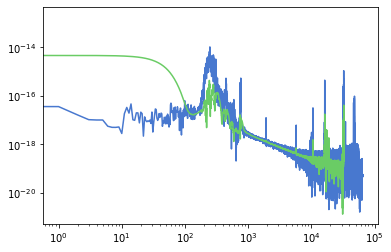

In [23]:
kernel_for_ps = gauss_kernel(freqs, 1)

convolved_ps = np.fft.rfft(np.fft.ifft(ps_L)*np.fft.ifft(kernel_for_ps))

denom = np.sum(np.abs(convolved_ps))
conv = np.abs(convolved_ps)



plt.loglog(np.abs(ps_L))
plt.loglog(8000*conv)